In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

In [20]:
df = pd.read_csv('merged_car_sales_with_features.csv')

df['waktu'] = pd.to_datetime(df['waktu'])
df = df.set_index('waktu')

df.info()
print(df.describe())
print(df.head(60))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55 entries, 2021-01-01 to 2025-08-01
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DAIHATSU                   55 non-null     float64
 1   HONDA                      55 non-null     float64
 2   MITSUBISHI                 55 non-null     float64
 3   SUZUKI                     55 non-null     float64
 4   TOYOTA                     55 non-null     float64
 5   bi_policy_rate_pct         55 non-null     object 
 6   inflation_yoy_pct          55 non-null     object 
 7   consumer_confidence_index  55 non-null     object 
 8   is_lebaran_season          55 non-null     int64  
 9   is_giias_month             55 non-null     int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 4.7+ KB
           DAIHATSU         HONDA    MITSUBISHI        SUZUKI        TOYOTA  \
count     55.000000     55.000000     55.000000     55.000000   

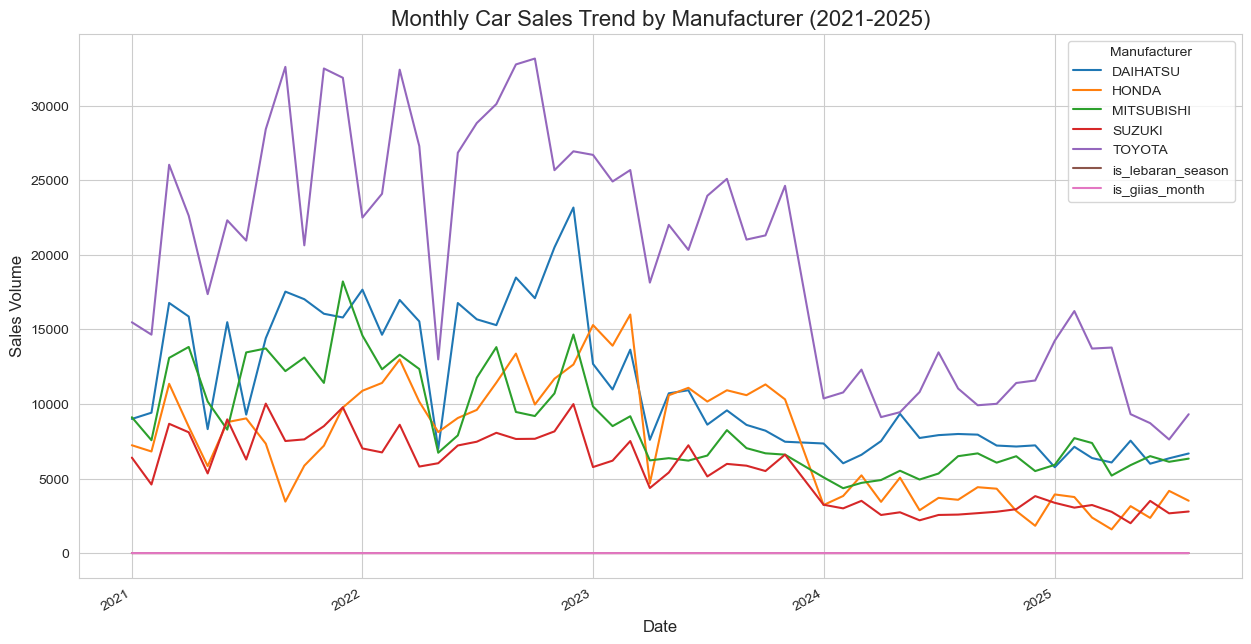

In [21]:
df.plot(figsize=(15, 8), linestyle='-')
plt.title('Monthly Car Sales Trend by Manufacturer (2021-2025)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.legend(title='Manufacturer')
plt.grid(True)
plt.show()

In [22]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# --- 1. データ準備 ---
df = pd.read_csv('merged_car_sales_with_features.csv')
df['waktu'] = pd.to_datetime(df['waktu'])
df = df.set_index('waktu')

# データ型のクレンジング
cols_to_clean = ['bi_policy_rate_pct', 'inflation_yoy_pct', 'consumer_confidence_index']
for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

# --- 2. 特徴量エンジニアリング ---
def create_features(df):
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

df = create_features(df)
TARGETS = ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']

for brand in TARGETS:
    df[f'{brand}_lag1'] = df[brand].shift(1)
    df[f'{brand}_lag3'] = df[brand].shift(3)
    df[f'{brand}_rolling_mean3'] = df[brand].shift(1).rolling(window=3).mean()
    df[f'{brand}_rolling_std3'] = df[brand].shift(1).rolling(window=3).std()

df = df.dropna()

# --- 3. データ分割の準備 ---
FEATURES = [col for col in df.columns if col not in TARGETS]
X = df[FEATURES]
y = df[TARGETS]

TRAIN_END = '2024-12-31'
X_train, y_train = X.loc[X.index <= TRAIN_END], y.loc[y.index <= TRAIN_END]
X_val, y_val = X.loc[X.index > TRAIN_END], y.loc[y.index > TRAIN_END]

In [23]:
from sklearn.model_selection import GridSearchCV # <-- GridSearchCVをインポート

# --- (データ準備、特徴量作成、データ分割のコードは同じ) ---

# --- パラメータチューニングとモデル学習 ---

# 1. GridSearchCV用に、試したいパラメータの具体的な値を定義
#    前のRandomizedSearchで見つかったベストな値を中心に設定するのが効果的
param_grid_grid = {
    'n_estimators': [1000, 1200, 1500],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [4, 5, 6],
    'num_leaves': [30, 40, 50],
    'reg_lambda': [2.0, 3.0],
    'reg_alpha': [0.1, 0.5]
    # subsampleとcolsample_bytreeはベスト値に固定するか、選択肢を絞る
    # 'subsample': [0.8], 
    # 'colsample_bytree': [0.7]
}

# (ベース特徴量の定義は同じ)
base_features = [
    'month', 'year', 'bi_policy_rate_pct', 'inflation_yoy_pct',
    'consumer_confidence_index', 'is_lebaran_season', 'is_giias_month'
]

models = {}
for target in TARGETS:
    print(f"\nTraining and tuning LightGBM model for {target} with GridSearchCV...")
    
    # (特徴量選択のロジックは同じ)
    target_specific_features = [col for col in X_train.columns if col.startswith(target)]
    features_for_this_model = base_features + target_specific_features
    X_train_filtered = X_train[features_for_this_model]
    X_val_filtered = X_val[features_for_this_model]
    
    print(f"  - Using {len(features_for_this_model)} features.")
    
    # LightGBMモデルの定義
    model = lgb.LGBMRegressor(
        objective='regression',
        random_state=42
    )
    
    # ★ FIX: RandomizedSearchCV を GridSearchCV に変更
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid_grid, # param_distributions から param_grid に変更
        cv=5,
        scoring='neg_root_mean_squared_error',
        verbose=1,
        n_jobs=2
    )
    
    # フィルタリングしたデータで学習
    grid_search.fit(
        X_train_filtered, y_train[target],
        eval_set=[(X_val_filtered, y_val[target])],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    # 最も性能が良かったモデルを保存
    print(f"Best parameters for {target}: {grid_search.best_params_}")
    models[target] = grid_search.best_estimator_


Training and tuning LightGBM model for DAIHATSU with GridSearchCV...
  - Using 11 features.
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 8
[LightGBM] [Info] Start training from score 11985.364458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# (SMAPE関数の定義は省略)

# --- ★ FIX: ベースとなる共通特徴量をここで再定義 ---
base_features = [
    'month', 'year', 'bi_policy_rate_pct', 'inflation_yoy_pct',
    'consumer_confidence_index', 'is_lebaran_season', 'is_giias_month'
]

evaluation_results = []
print("\n--- Model Evaluation Metrics (Univariate Approach) ---")

# models辞書には、各ブランド専用に学習したモデルが格納されている
for target, model in models.items():
    
    # --- ★ FIX: 予測(predict)の前に、検証データもフィルタリングする ---
    # 1. このブランド自身のラグ/移動平均特徴量だけを抽出
    target_specific_features = [col for col in X_val.columns if col.startswith(target)]
    
    # 2. 共通特徴量とブランド専用特徴量を結合
    features_for_this_model = base_features + target_specific_features
    
    # 3. 選択した特徴量だけで検証データを作成
    X_val_filtered = X_val[features_for_this_model]
    
    # 4. フィルタリングした検証データで予測を実行
    y_pred = model.predict(X_val_filtered)
    
    # --- (これ以降の評価指標の計算は同じ) ---
    mae = mean_absolute_error(y_val[target], y_pred)
    mse = mean_squared_error(y_val[target], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val[target], y_pred)
    smape_score = smape(y_val[target], y_pred)
    
    results = {
        'Brand': target,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2,
        'SMAPE (%)': smape_score
    }
    evaluation_results.append(results)

# 結果をDataFrameで表示
results_df = pd.DataFrame(evaluation_results)
print(results_df.sort_values(by='SMAPE (%)').reset_index(drop=True))


--- Model Evaluation Metrics (Univariate Approach) ---
        Brand          MAE         RMSE  R-squared  SMAPE (%)
0  MITSUBISHI   909.229241  1072.663837  -0.961423  13.864250
1      SUZUKI   611.832676   715.014200  -1.572939  20.211115
2    DAIHATSU  1552.734236  1761.036849  -8.807193  21.293330
3      TOYOTA  4463.011408  5383.767729  -2.210342  35.333822
4       HONDA  1687.718984  1815.579428  -3.559901  47.456968


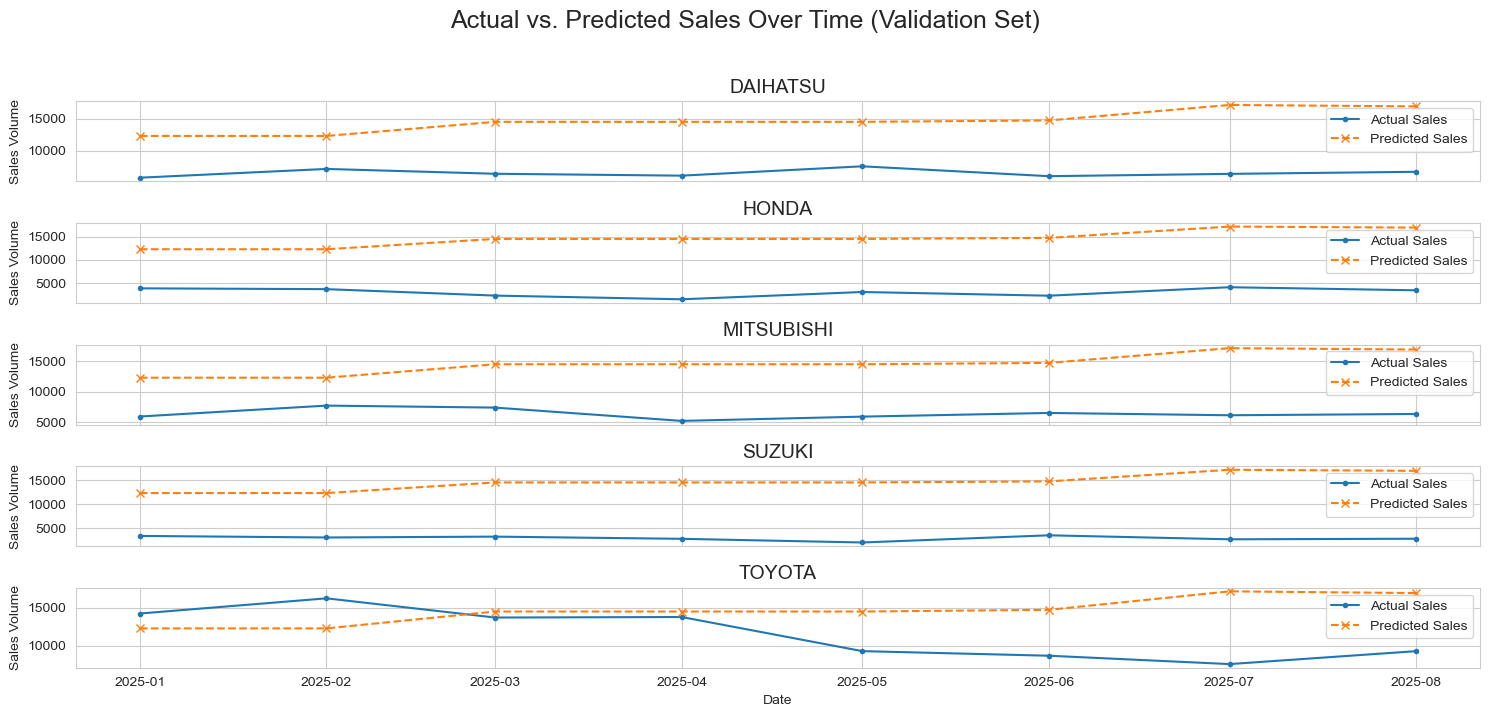

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for the plots
sns.set_style('whitegrid')

# Create subplots to visualize each model's predictions
# This will create a separate chart for each brand for clarity
fig, axes = plt.subplots(nrows=len(TARGETS), ncols=1, figsize = (15, 8), sharex=True)
fig.suptitle('Actual vs. Predicted Sales Over Time (Validation Set)', fontsize=18, y=0.92)

for i, target in enumerate(TARGETS):
    # Get the specific subplot
    ax = axes[i]
    
    # Use the trained model for the brand to make predictions
    
    # Plot the actual sales data from the validation set
    ax.plot(y_val.index, y_val[target], label='Actual Sales', marker='.', linestyle='-')
    
    # Plot the model's predicted sales on top
    ax.plot(y_val.index, y_pred, label='Predicted Sales', marker='x', linestyle='--')
    
    # Set titles and labels for clarity
    ax.set_title(target, fontsize=14)
    ax.set_ylabel('Sales Volume')
    ax.legend()

plt.xlabel('Date')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

LightGBMError: The number of features in data (27) is not the same as it was in training data (11).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

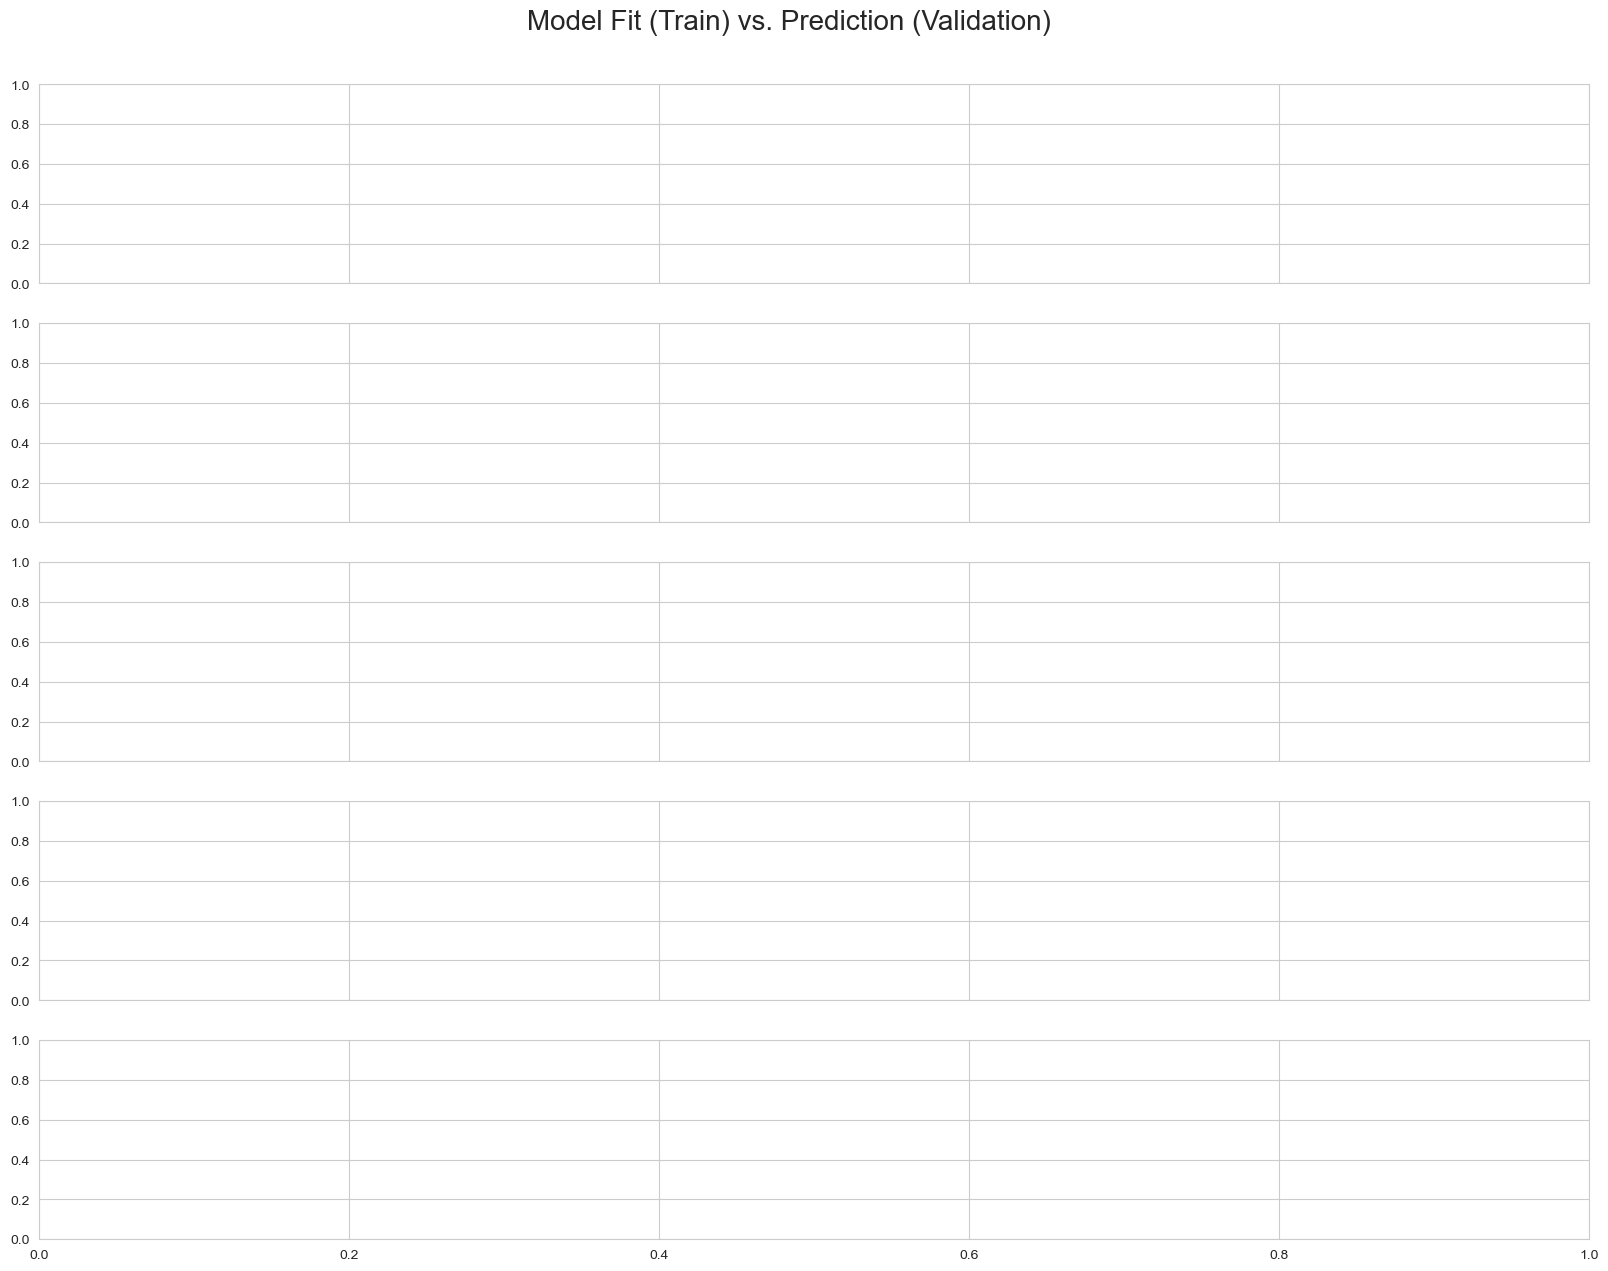

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # T

sns.set_style('whitegrid')


fig, axes = plt.subplots(nrows=len(TARGETS), ncols=1, figsize=(20, 15), sharex=True)
fig.suptitle('Model Fit (Train) vs. Prediction (Validation)', fontsize=20, y=0.93)

for i, target in enumerate(TARGETS):
    ax = axes[i]
    
    pred_train = models[target].predict(X_train)
    pred_val = models[target].predict(X_val)
    
    ax.plot(y_train.index, y_train[target], label='Actual (Train)', color='skyblue', marker='.', linestyle='-')
    ax.plot(y_val.index, y_val[target], label='Actual (Validation)', color='darkblue', marker='.', linestyle='-')
    
    ax.plot(X_train.index, pred_train, label='Predicted (Train Fit)', linestyle='--', color='orange')
    ax.plot(X_val.index, pred_val, label='Predicted (Validation)', linestyle='--', color='red')
    

    ax.axvline(pd.to_datetime(TRAIN_END), color='green', linestyle=':', lw=2, label='Train/Val Split')


    ax.set_title(target, fontsize=16)
    ax.set_ylabel('Sales Volume')
    ax.legend(loc='upper left')

plt.xlabel('Date', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

In [ ]:
import numpy as np

# --- 季節性ナイーブ予測の作成 ---
# 検証期間y_valに対応する、1年前の訓練期間のデータを取得
y_train_seasonal_naive = y_train.loc[y_val.index - pd.DateOffset(years=1)]

# SMAPEを計算する関数 (再掲)
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    ratio = np.where(denominator == 0, 0, numerator / denominator)
    return np.mean(ratio) * 100

# 全ブランドで評価
for target in TARGETS:
    # y_val[target] (実際の値) と y_train_seasonal_naive[target] (1年前の値) を比較
    naive_smape = smape(y_val[target].values, y_train_seasonal_naive[target].values)
    print(f"Seasonal Naive Forecast SMAPE for {target}: {naive_smape:.2f}%")

Seasonal Naive Forecast SMAPE for DAIHATSU: 19.13%
Seasonal Naive Forecast SMAPE for HONDA: 35.38%
Seasonal Naive Forecast SMAPE for MITSUBISHI: 24.12%
Seasonal Naive Forecast SMAPE for SUZUKI: 14.64%
Seasonal Naive Forecast SMAPE for TOYOTA: 28.81%


ValueError: All arrays must be of the same length

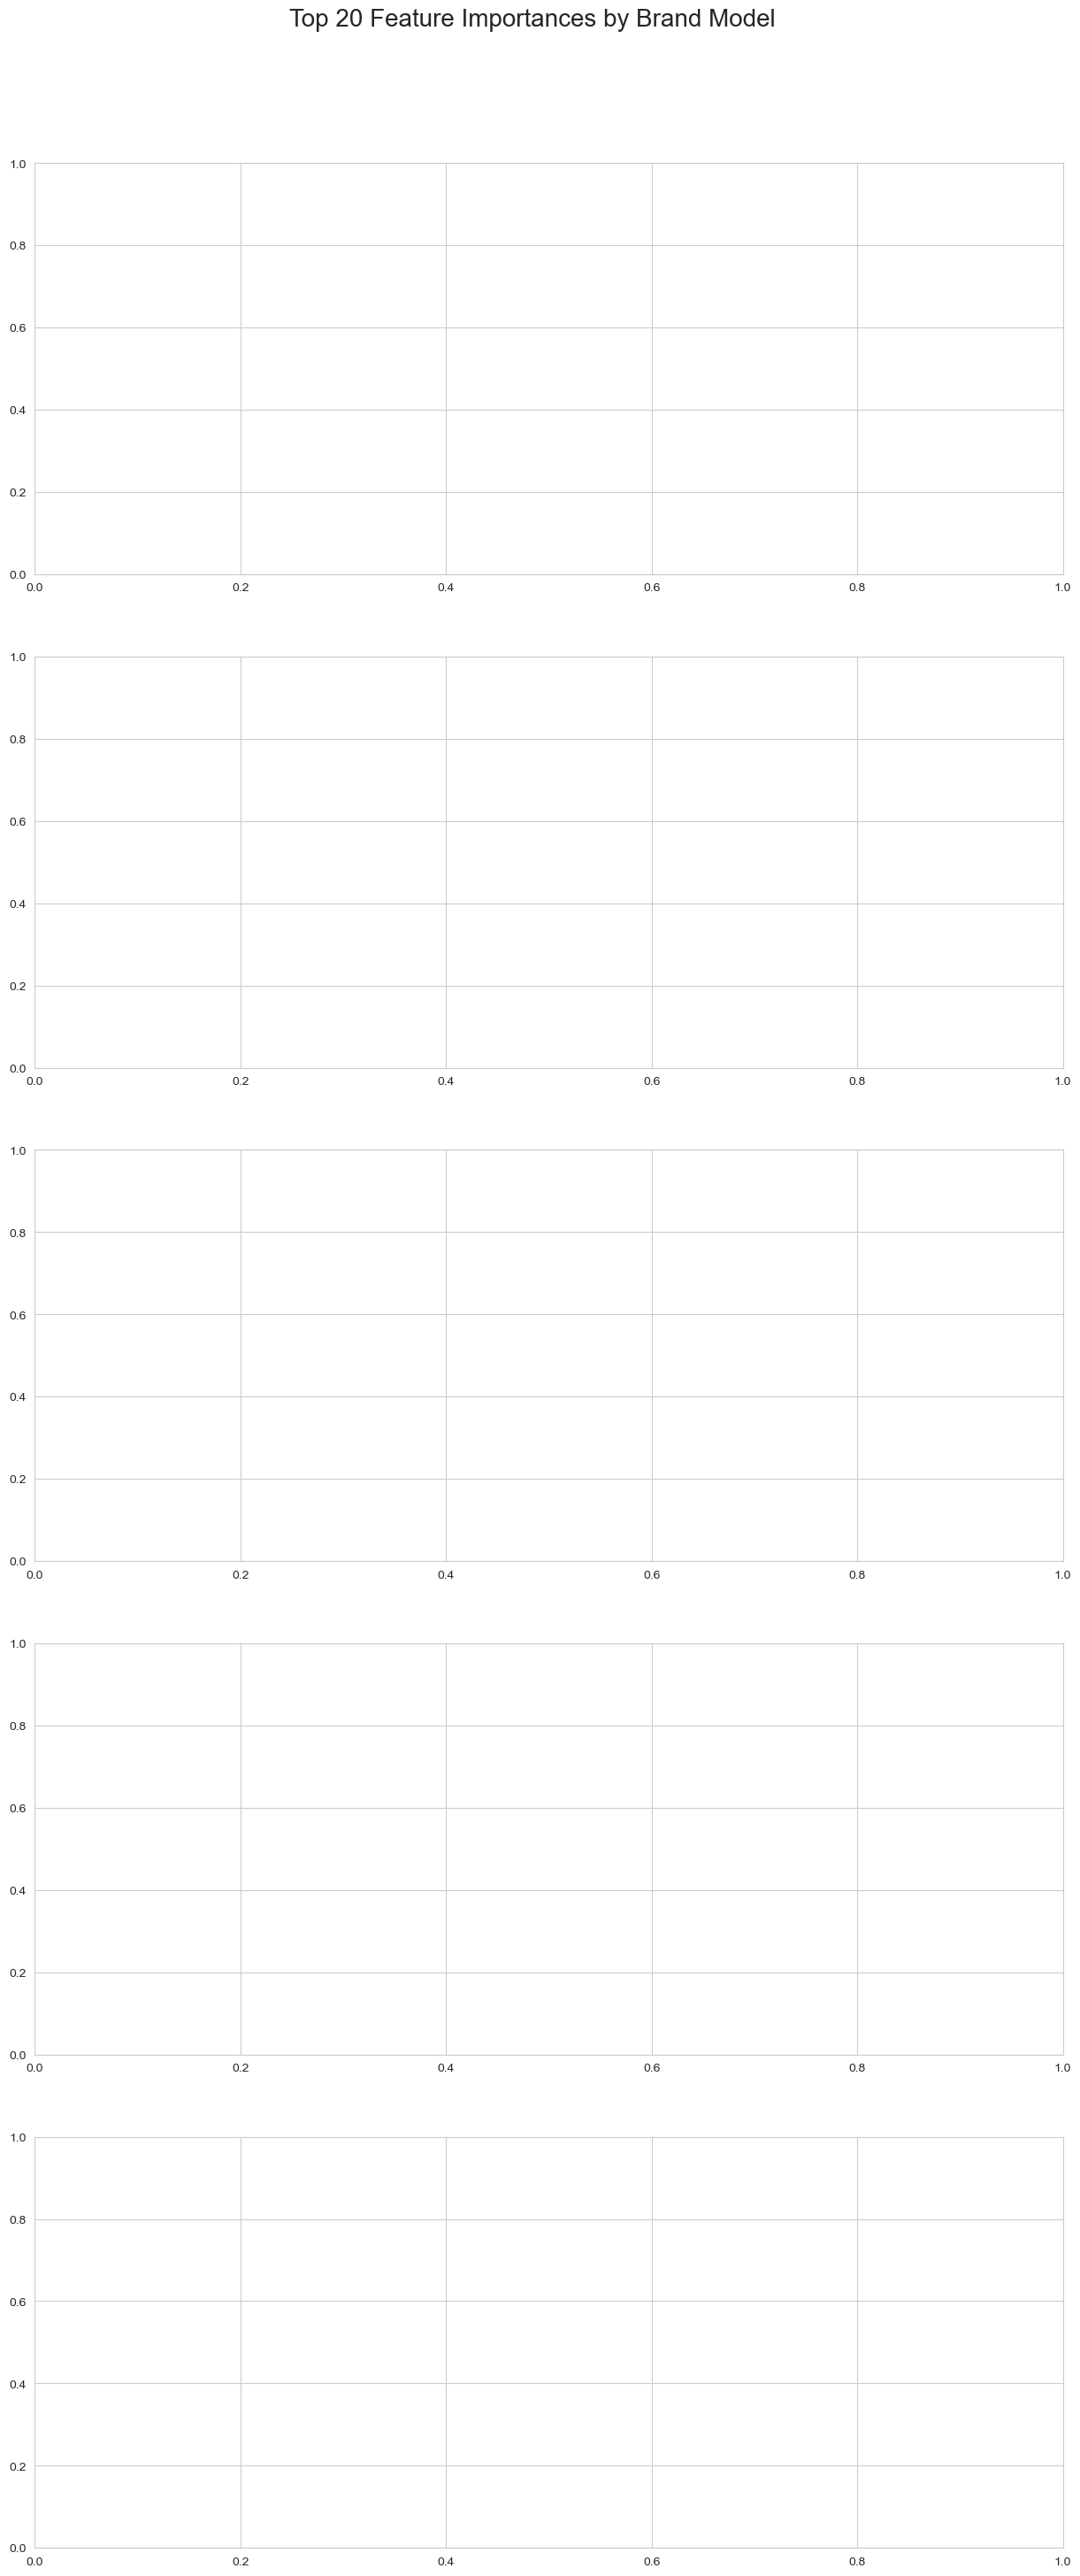

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# グラフのスタイルを設定
sns.set_style("whitegrid")

# 各ブランドのグラフを縦に並べて表示するための準備
num_targets = len(TARGETS)
fig, axes = plt.subplots(nrows=num_targets, ncols=1, figsize=(15, 7 * num_targets))

# ターゲットが1つの場合でもエラーにならないように調整
if num_targets == 1:
    axes = [axes]

fig.suptitle('Top 20 Feature Importances by Brand Model', fontsize=20, y=0.93)

# 各ブランドの学習済みモデルに対してループ処理
for i, (target, model) in enumerate(models.items()):
    ax = axes[i]
    
    # 特徴量の名前と、その重要度をデータフレームにまとめる
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    })
    
    # 重要度が高い順にソートし、上位20個を抽出
    top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)
    
    # 棒グラフを作成
    sns.barplot(x='Importance', y='Feature', data=top_features, ax=ax)
    
    ax.set_title(f'Feature Importance for {target}', fontsize=16)
    ax.set_xlabel('Importance Score', fontsize=12)
    ax.set_ylabel('Feature Name', fontsize=12)

# グラフのレイアウトを調整して表示
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()